# BBC-embeddings dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceSubsample,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: bbc-embeddings
- Model: transformer's pretrained DistilBertModel + LogisticRegression
- Metric: Classification accuracy

In [2]:
dataset_name = "bbc-embeddings" 
train_count, valid_count, test_count = 1000, 100, 500
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate, 'sigma': 2.0}
model_name = "LogisticRegression" # will train a logistic regression model built with PyTorch
metric_name = "accuracy"
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
device = torch.device('cuda')

# feature extraction is performed when the following code is executed. (cpu takes 10-ish mins)
exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=add_gauss_noise,
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    device=device,
    model_name=model_name,
    metric_name=metric_name
)

/burg/home/yk3012/repos/opendataval/opendataval/dataloader/fetcher.py:270: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float).view(-1, *self.covar_dim)


Base line model metric_name='accuracy': perf=0.9559999704360962


## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceSubsample(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley ## slow
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley ## slow
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
#     RobustVolumeShapley(mc_epochs=300)
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.002342


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.17it/s]


Elapsed time LeaveOneOut(): 0:00:38.250688


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.62it/s]


Elapsed time InfluenceSubsample(num_models=1000): 0:00:27.317174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 163.22it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:12.423984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 11174.28it/s]


Elapsed time KNNShapley(k_neighbors=100): 0:00:00.131385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.08it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:20.825358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.51it/s]


Elapsed time AME(num_models=1000): 0:01:22.153797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.86it/s]


Elapsed time DataOob(num_models=1000): 0:00:40.234312


Elapsed time LavaEvaluator(): 0:00:00.241724
CPU times: user 3min 35s, sys: 3 s, total: 3min 38s
Wall time: 3min 41s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/bbc-embeddings_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.180164
DVRL(rl_epochs=2000),0.156673
DataBanzhaf(num_models=1000),0.195205
DataOob(num_models=1000),0.500000
InfluenceSubsample(num_models=1000),0.196399
KNNShapley(k_neighbors=100),0.362976
LavaEvaluator(),1.000000
LeaveOneOut(),0.170068
RandomEvaluator(),0.176570


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

/burg/home/yk3012/repos/opendataval/opendataval/dataloader/fetcher.py:270: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float).view(-1, *self.covar_dim)


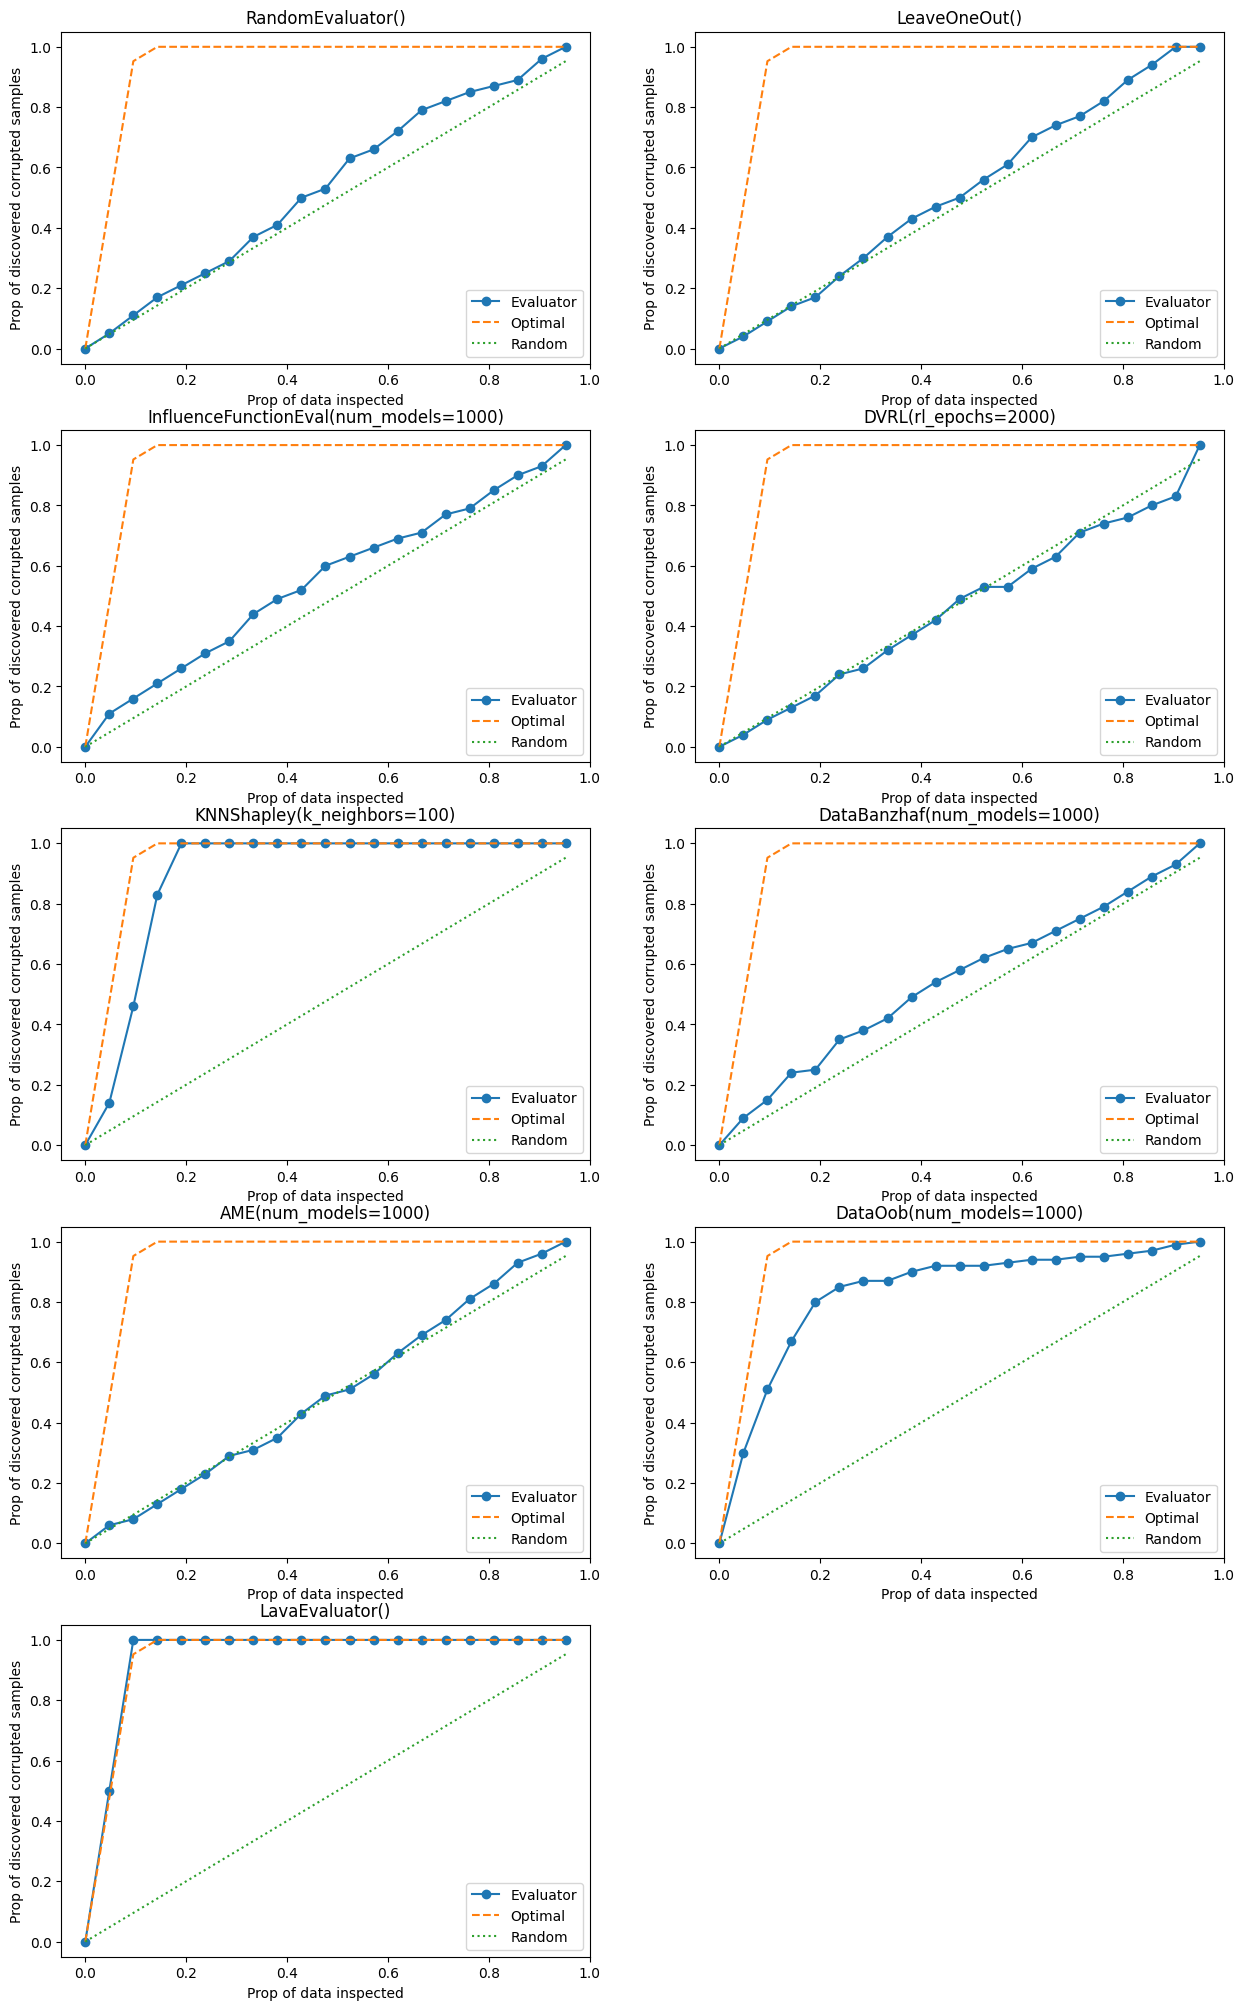

In [7]:
fig = plt.figure(figsize=(15, 25))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

/burg/home/yk3012/repos/opendataval/opendataval/dataloader/fetcher.py:270: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float).view(-1, *self.covar_dim)


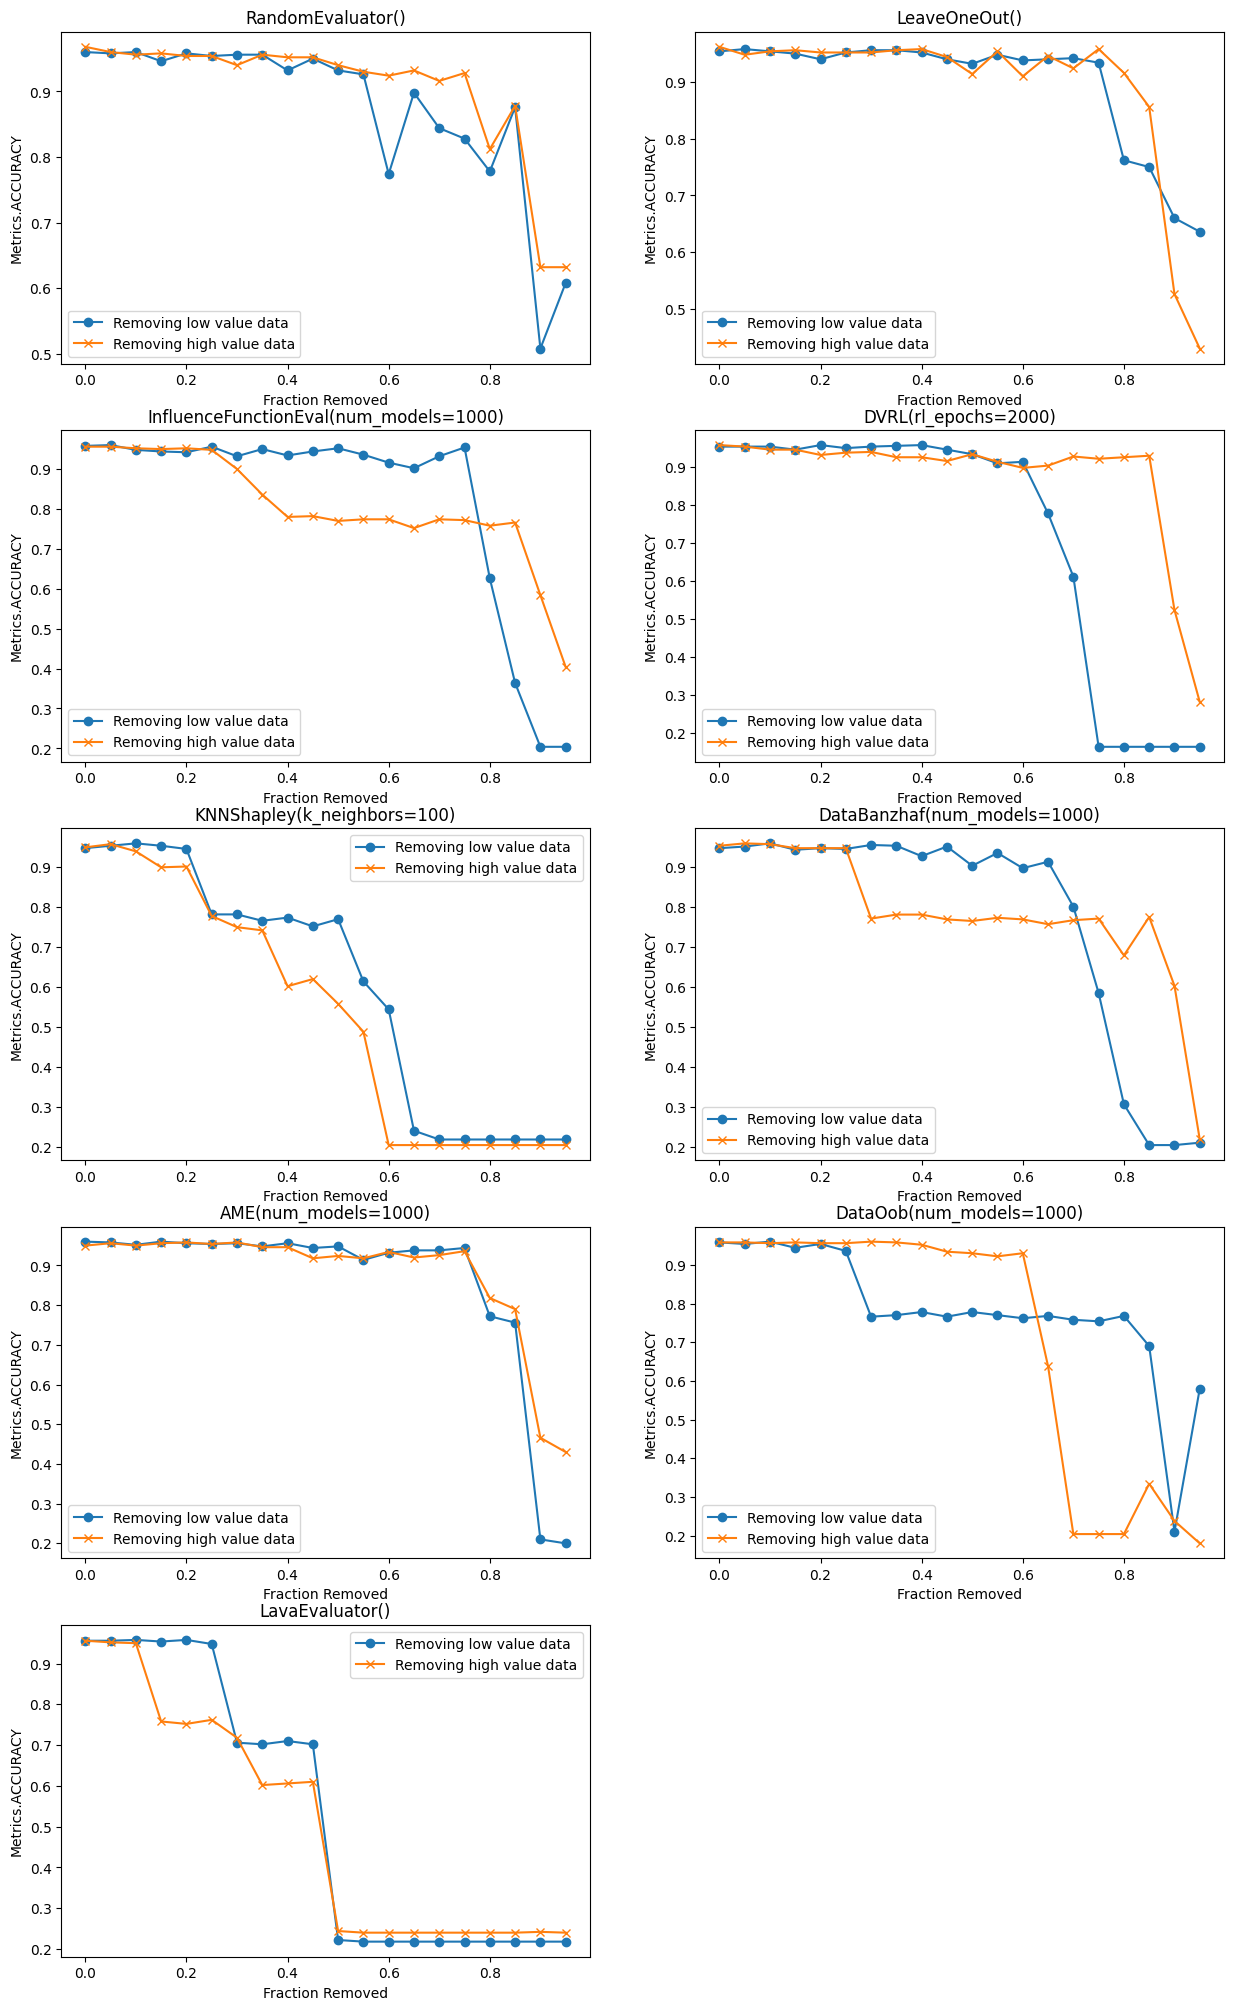

In [8]:
fig = plt.figure(figsize=(15, 25))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.96,0.968,0.0
RandomEvaluator(),0.958,0.96,0.05
RandomEvaluator(),0.96,0.956,0.1
RandomEvaluator(),0.946,0.958,0.15
RandomEvaluator(),0.958,0.954,0.2
...,...,...,...
LavaEvaluator(),0.218,0.24,0.75
LavaEvaluator(),0.218,0.24,0.8
LavaEvaluator(),0.218,0.24,0.85
LavaEvaluator(),0.218,0.242,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),1151,0.939612
RandomEvaluator(),667,0.482234
RandomEvaluator(),1138,0.321678
RandomEvaluator(),1460,0.596709
RandomEvaluator(),1373,0.134667
...,...,...
LavaEvaluator(),1784,164.598557
LavaEvaluator(),863,-1361.261963
LavaEvaluator(),250,148.774826
LavaEvaluator(),728,147.790466
